In [1036]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1037]:
df = pd.read_csv('./datasets/house_prices.csv')
df.shape

(15327, 17)

In [1038]:
df.head()

,Title,Sub_title,Price,Address,Baths,Land size,Beds,House size,Location,Description,Post_URL,Seller_name,Seller_type,published_date,Geo_Address,Lat,Lon
0,House with Land for Sale in Matara for sale,"Posted on 06 Nov 2:32 pm, Matara City, Matara","Rs 5,400,000","Gangodagama Roard,Hakmana,Matara.",1,50.0 perches,3,"1,600.0 sqft","Matara City, Matara","Land for sale with house Matara,Hakmana Gangod...",https://ikman.lk/en/ad/house-with-land-for-sal...,Ishara Dilshan,Member,2021-11-06 14:32:00,"Matara City, Matara, Sri Lanka",80.500000,6.166670
1,à¶ à¶½à·à¶­à· à¶à·à¶¸à¶» 3 à¶ à¶à·à· à...,"Posted on 24 Oct 7:27 am, Athurugiriya, Colombo","Rs 16,800,000",Athurugiriya Galwarusapare,3,8.0 perches,3,"1,480.0 sqft","Athurugiriya, Colombo",*House For Sale In Athurugiriya *Galwarusapare...,https://ikman.lk/en/ad/alut-kaamr-3-k-grh-bhaa...,DILRUWAN REAL ESTATE,Premium-Member,2021-10-24 07:27:00,"Athurugiriya, Colombo, Sri Lanka",79.989929,6.877246
2,Kelaniya - House on 20P Land for sale for sale,"Posted on 17 Nov 5:19 pm, Kelaniya, Gampaha","Rs 20,000,000",Kelaniya- Ranaviru Maldeniya Road,2,20.0 perches,3,"2,800.0 sqft","Kelaniya, Gampaha","Kelaniya- Biyagama road, Ranaviru Maladeniya R...",https://ikman.lk/en/ad/kelaniya-house-on-20p-l...,Provident Paradise (Pvt) Ltd,Member,2021-11-17 17:19:00,"Kelaniya, Gampaha, Sri Lanka",79.914926,6.951178
3,House For Sale in Pamankada Lane Wellawatte Co...,"Posted on 17 Nov 5:07 pm, Colombo 6, Colombo","Rs 187,000,000",Pamankada Lane Wellawatte Colombo.06,5,22.0 perches,5,"4,000.0 sqft","Colombo 6, Colombo",22 Perches House For Sale in Pamankada Lane We...,https://ikman.lk/en/ad/house-for-sale-in-paman...,Colombo Construction Property Developers,Premium-Member,2021-11-17 17:07:00,"Colombo 6, Colombo, Sri Lanka",80.016670,6.866670
4,House For Sale - Attidiya for sale,"Posted on 17 Nov 5:06 pm, Dehiwala, Colombo","Rs 1,300,000",MainRoad Attidiya,1,6.3 perches,2,900.0 sqft,"Dehiwala, Colombo",*à¶ à¶­à·à¶­à·à¶©à·à¶º à¶´à·âà¶»à¶¯à·à·...,https://ikman.lk/en/ad/house-for-sale-attidiya...,Lakdinu Houses,Member,2021-11-17 17:06:00,"Dehiwala, Colombo, Sri Lanka",79.880242,6.838232


In [1039]:
# rename columns
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ', '_')
df.columns

Index(['title', 'sub_title', 'price', 'address', 'baths', 'land_size', 'beds',
       'house_size', 'location', 'description', 'post_url', 'seller_name',
       'seller_type', 'published_date', 'geo_address', 'lat', 'lon'],
      dtype='object')

In [1040]:
# switch lat and lon
df = df.rename(columns={'lat': 'lon', 'lon': 'lat'})

In [1041]:
# remove unnecessary columns
df = df.drop(columns=
       ['title', 'sub_title', 'address', 'post_url', 'seller_name', 'seller_type', 'location', 'description'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15327 entries, 0 to 15326
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           15327 non-null  object 
 1   baths           15327 non-null  object 
 2   land_size       15327 non-null  object 
 3   beds            15327 non-null  object 
 4   house_size      15327 non-null  object 
 5   published_date  15327 non-null  object 
 6   geo_address     15327 non-null  object 
 7   lon             15327 non-null  float64
 8   lat             15327 non-null  float64
dtypes: float64(2), object(7)
memory usage: 1.1+ MB


In [1042]:
# split location info
df[['loc_1', 'loc_2', 'loc_3']] = df['geo_address'].str.split(',', n=2, expand=True)

df['loc_1'] = df['loc_1'].str.strip().str.lower()
df['loc_2'] = df['loc_2'].str.strip().str.lower()
df['loc_3'] = df['loc_3'].str.strip().str.lower()

loc_1 = df['loc_1'].unique()
loc_2 = df['loc_2'].unique()
loc_3 = df['loc_3'].unique()

print('loc_1: ', loc_1[:5], loc_1.shape[0])
print('loc_2: ', loc_2[:5], loc_2.shape[0])
print('loc_3: ', loc_3[:5], loc_3.shape[0])

loc_1:  ['matara city' 'athurugiriya' 'kelaniya' 'colombo 6' 'dehiwala'] 172
loc_2:  ['matara' 'colombo' 'gampaha' 'kandy' 'jaffna'] 24
loc_3:  ['sri lanka'] 1


In [1043]:
# drop loc_3 since no variation
df = df.drop(columns=['geo_address', 'loc_3'])

# rename loc_1 and loc_2
df = df.rename(columns={'loc_1': 'city', 'loc_2': 'district'})

districts = loc_2
cities = loc_1

In [1044]:
#split units and values
df[['price_unit', 'price']] = df['price'].str.split(' ', n=1, expand=True)
df[['house_size', 'house_size_unit']] = df['house_size'].str.split(' ', n=1, expand=True)
df[['land_size', 'land_size_unit']] = df['land_size'].str.split(' ', n=1, expand=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15327 entries, 0 to 15326
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            15327 non-null  object 
 1   baths            15327 non-null  object 
 2   land_size        15327 non-null  object 
 3   beds             15327 non-null  object 
 4   house_size       15327 non-null  object 
 5   published_date   15327 non-null  object 
 6   lon              15327 non-null  float64
 7   lat              15327 non-null  float64
 8   city             15327 non-null  object 
 9   district         15327 non-null  object 
 10  price_unit       15327 non-null  object 
 11  house_size_unit  15327 non-null  object 
 12  land_size_unit   15327 non-null  object 
dtypes: float64(2), object(11)
memory usage: 1.5+ MB


In [1045]:
# analyse numeric values to find non-numeric characters
df['price_numeric'] = pd.to_numeric(df['price'], errors='coerce')
df['house_size_numeric'] = pd.to_numeric(df['house_size'], errors='coerce')
df['land_size_numeric'] = pd.to_numeric(df['land_size'], errors='coerce')
df['baths_numeric'] = pd.to_numeric(df['baths'], errors='coerce')
df['beds_numeric'] = pd.to_numeric(df['beds'], errors='coerce')
df['published_date_datetime'] = pd.to_datetime(df['published_date'], errors='coerce')

print('price:', df[df['price_numeric'].isna()]['price'].unique()[:10])   
print('house_size:', df[df['house_size_numeric'].isna()]['house_size'].unique()[:10])
print('land_size:', df[df['land_size_numeric'].isna()]['land_size'].unique()[:10])
print('baths:', df[df['baths_numeric'].isna()]['baths'].unique()[:10])
print('beds:', df[df['beds_numeric'].isna()]['beds'].unique()[:10])
print('published_date:', df[df['published_date_datetime'].isna()]['published_date'].unique()[:10])

price: ['5,400,000' '16,800,000' '20,000,000' '187,000,000' '1,300,000'
 '55,000,000' '45,000,000' '16,700,000' '50,000,000' '16,000,000']
house_size: ['1,600.0' '1,480.0' '2,800.0' '4,000.0' '3,300.0' '4,100.0' '1,400.0'
 '2,000.0' '5,000.0' '1,800.0']
land_size: ['3,000.0' '2,500.0' '3,500.0' '3,200.0' '1,350.0' '3,300.0' '5,445.0'
 '1,305.0' '1,500.0' '2,900.0']
baths: ['10+']
beds: ['10+']
published_date: []


In [1046]:
#replace ',' with ''
df.loc[df['price_numeric'].isna(), 'price_numeric'] = df['price'].str.replace(',', '').astype(float)
df.loc[df['house_size_numeric'].isna(), 'house_size_numeric'] = df['house_size'].str.replace(',', '').astype(float)
df.loc[df['land_size_numeric'].isna(), 'land_size_numeric'] = df['land_size'].str.replace(',', '').astype(float)

#replace 'x+' with 'x+1'
df.loc[df['baths_numeric'].isna(), 'baths_numeric'] = df['baths'].str.replace('+', '').astype(int) + 1
df.loc[df['beds_numeric'].isna(), 'beds_numeric'] = df['beds'].str.replace('+', '').astype(int) + 1

print('price:', df[df['price_numeric'].isna()]['price'].unique()[:10])   
print('house_size:', df[df['house_size_numeric'].isna()]['house_size'].unique()[:10])
print('land_size:', df[df['land_size_numeric'].isna()]['land_size'].unique()[:10])
print('baths:', df[df['baths_numeric'].isna()]['baths'].unique()[:10])
print('beds:', df[df['beds_numeric'].isna()]['beds'].unique()[:10])
print('published_date:', df[df['published_date_datetime'].isna()]['published_date'].unique()[:10])

price: []
house_size: []
land_size: []
baths: []
beds: []
published_date: []


In [1047]:
df['price'] = df['price_numeric']
df['house_size'] = df['house_size_numeric']
df['land_size'] = df['land_size_numeric']
df['baths'] = df['baths_numeric']
df['beds'] = df['beds_numeric']
df['published_date'] = df['published_date_datetime']

df = df.drop(columns=
    ['price_numeric', 'house_size_numeric', 'land_size_numeric', 'baths_numeric', 'beds_numeric', 'published_date_datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15327 entries, 0 to 15326
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   price            15327 non-null  float64       
 1   baths            15327 non-null  float64       
 2   land_size        15327 non-null  float64       
 3   beds             15327 non-null  float64       
 4   house_size       15327 non-null  float64       
 5   published_date   15327 non-null  datetime64[ns]
 6   lon              15327 non-null  float64       
 7   lat              15327 non-null  float64       
 8   city             15327 non-null  object        
 9   district         15327 non-null  object        
 10  price_unit       15327 non-null  object        
 11  house_size_unit  15327 non-null  object        
 12  land_size_unit   15327 non-null  object        
dtypes: datetime64[ns](1), float64(7), object(5)
memory usage: 1.5+ MB


In [1048]:
#find different units used
print('price_unit: ', df['price_unit'].unique())
print('house_size_unit: ', df['house_size_unit'].unique())
print('land_size_unit: ', df['land_size_unit'].unique())

price_unit:  ['Rs']
house_size_unit:  ['sqft']
land_size_unit:  ['perches' 'acres']


In [1049]:
#convert acres to perches
df.loc[df['land_size_unit'] == 'acres', 'land_size'] *= 160
df = df.drop(columns=['price_unit', 'house_size_unit', 'land_size_unit'])
df.describe()

,price,baths,land_size,beds,house_size,published_date,lon,lat
count,1.532700e+04,15327.000000,15327.000000,15327.000000,15327.000000,15327,15327.000000,15327.000000
mean,3.534340e+07,2.976577,17.692467,3.991388,2770.713588,2021-11-10 09:27:24.450968832,79.979304,6.908008
min,3.600000e+03,1.000000,0.000000,1.000000,0.000000,2021-09-19 21:01:00,79.795675,5.941424
25%,1.650000e+07,2.000000,7.800000,3.000000,1650.000000,2021-10-31 12:03:00,79.913892,6.801844
50%,2.600000e+07,3.000000,10.000000,4.000000,2500.000000,2021-11-12 14:16:00,79.940789,6.866670
75%,3.950000e+07,4.000000,14.250000,4.000000,3300.000000,2021-11-21 10:49:30,80.000000,6.935757
max,1.900000e+09,11.000000,6400.000000,11.000000,120000.000000,2021-11-29 01:35:00,81.822554,9.673491
std,4.513401e+07,1.364254,117.072783,1.272811,2194.920377,NaN,0.177783,0.243448


In [1050]:
# feature engineering
df['sqft_per_bed'] = df['house_size'] / df['beds']
df['house_land_ratio'] = df['house_size'] / df['land_size'] / 272.25 #floor count
df['garden_size'] = (df['land_size'] * 272.25) - (df['house_size'] / np.ceil(df['house_land_ratio']))
df['baths_per_bed'] = df['baths'] / df['beds']
# distance to nearest city
# distance to nearest school
# distance to nearest hospital
# ocean proximity

# for outlier detection
df['price_per_house_size'] = df['price'] / df['house_size']
df['price_per_land_size'] = df['price'] / df['land_size']

df.describe()

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,price,baths,land_size,beds,house_size,published_date,lon,lat,sqft_per_bed,house_land_ratio,garden_size,baths_per_bed,price_per_house_size,price_per_land_size
count,1.532700e+04,15327.000000,15327.000000,15327.000000,15327.000000,15327,15327.000000,15327.000000,15327.000000,1.532700e+04,1.532200e+04,15327.000000,1.532700e+04,1.532700e+04
mean,3.534340e+07,2.976577,17.692467,3.991388,2770.713588,2021-11-10 09:27:24.450968832,79.979304,6.908008,689.037998,inf,2.858918e+03,0.741576,inf,inf
min,3.600000e+03,1.000000,0.000000,1.000000,0.000000,2021-09-19 21:01:00,79.795675,5.941424,0.000000,0.000000e+00,0.000000e+00,0.142857,1.000000e+00,4.615385e+02
25%,1.650000e+07,2.000000,7.800000,3.000000,1650.000000,2021-10-31 12:03:00,79.913892,6.801844,500.000000,5.772006e-01,5.418750e+02,0.600000,8.412698e+03,1.547619e+06
50%,2.600000e+07,3.000000,10.000000,4.000000,2500.000000,2021-11-12 14:16:00,79.940789,6.866670,633.333333,9.182736e-01,9.336667e+02,0.750000,1.033333e+04,2.619048e+06
75%,3.950000e+07,4.000000,14.250000,4.000000,3300.000000,2021-11-21 10:49:30,80.000000,6.935757,787.500000,1.253173e+00,1.489500e+03,1.000000,1.325000e+04,4.000000e+06
max,1.900000e+09,11.000000,6400.000000,11.000000,120000.000000,2021-11-29 01:35:00,81.822554,9.673491,13333.333333,inf,1.731510e+06,2.666667,inf,inf
std,4.513401e+07,1.364254,117.072783,1.272811,2194.920377,NaN,0.177783,0.243448,448.696275,NaN,3.180611e+04,0.242976,NaN,NaN


In [1051]:
#remove outliers using domain knowledge
size_before = df.shape[0]

sqft_per_bed_outliers_low = df[df['sqft_per_bed'] < 100].index
sqft_per_bed_outliers_high = df[df['sqft_per_bed'] > 1000].index

land_size_outliers = df[df['land_size'] < 5].index

price_per_land_size_outliers = df[df['price_per_land_size'] < 50000].index

baths_per_bed_outliers = df[df['baths_per_bed'] > 1.5].index

df = df.drop(set([*sqft_per_bed_outliers_low, *sqft_per_bed_outliers_high, *land_size_outliers, *price_per_land_size_outliers, *baths_per_bed_outliers]))

#print outlier counts
print('sqft_per_bed_outliers: ', len(sqft_per_bed_outliers_low) + len(sqft_per_bed_outliers_high))
print('land_size_outliers: ', len(land_size_outliers))
print('price_per_land_size_outliers: ', len(price_per_land_size_outliers))
print('baths_per_bed_outliers: ', len(baths_per_bed_outliers))
print()
print('size before: ', size_before)
print('size after: ', df.shape[0])

df.describe()

sqft_per_bed_outliers:  1261
land_size_outliers:  402
price_per_land_size_outliers:  54
baths_per_bed_outliers:  23

size before:  15327
size after:  13626


,price,baths,land_size,beds,house_size,published_date,lon,lat,sqft_per_bed,house_land_ratio,garden_size,baths_per_bed,price_per_house_size,price_per_land_size
count,1.362600e+04,13626.000000,13626.000000,13626.000000,13626.000000,13626,13626.000000,13626.000000,13626.000000,13626.000000,13626.000000,13626.000000,13626.000000,1.362600e+04
mean,3.225902e+07,2.933950,13.344613,4.002495,2526.986285,2021-11-10 09:25:27.653016064,79.976165,6.907337,629.563249,0.900617,1755.473218,0.730820,12357.483562,2.954213e+06
min,9.250000e+05,1.000000,5.000000,1.000000,200.000000,2021-09-19 21:01:00,79.795675,5.941424,100.000000,0.003673,0.000000,0.142857,350.000000,5.102041e+04
25%,1.680000e+07,2.000000,8.000000,3.000000,1650.000000,2021-10-31 12:03:00,79.913892,6.801844,500.000000,0.550964,578.000000,0.600000,8430.870051,1.523810e+06
50%,2.550000e+07,3.000000,10.000000,4.000000,2500.000000,2021-11-12 14:16:00,79.927391,6.866670,625.000000,0.864258,972.500000,0.750000,10250.000000,2.523810e+06
75%,3.600000e+07,4.000000,13.200000,4.000000,3120.000000,2021-11-21 10:30:00,79.989929,6.932625,750.000000,1.224365,1447.750000,1.000000,13076.923077,3.815385e+06
max,1.150000e+09,11.000000,2500.000000,11.000000,11000.000000,2021-11-29 01:35:00,81.822554,9.673491,1000.000000,4.000334,678125.000000,1.500000,262800.000000,5.227273e+07
std,3.313239e+07,1.260859,27.204052,1.221096,1022.102405,NaN,0.171420,0.246697,171.812076,0.438003,7321.106262,0.232694,10224.410284,2.586092e+06


In [1052]:
# remove outliers using z-score
def detect_outliers(df, threshold, features):
    outliers = []

    for f in features:
        sub_df = df[f].copy()
        mean = np.mean(df[f])
        std = np.std(df[f])
        sub_df['z_score'] = (df[f] - mean) / std
        outliers.extend(df[sub_df['z_score'] > threshold].index.tolist())
        outliers.extend(df[sub_df['z_score'] < -threshold].index.tolist())

    return outliers

print('before:', df.shape[0])

outliers = detect_outliers(df, 2, [ 'sqft_per_bed', 'price_per_house_size', 'price_per_land_size', 'land_size', 'house_size', 'price'])

df = df.drop(outliers)
df = df.drop(columns=['price_per_house_size', 'price_per_land_size'])

print('after:', df.shape[0])

df.describe()


before: 13626
after: 12067


,price,baths,land_size,beds,house_size,published_date,lon,lat,sqft_per_bed,house_land_ratio,garden_size,baths_per_bed
count,1.206700e+04,12067.000000,12067.000000,12067.000000,12067.000000,12067,12067.000000,12067.000000,12067.000000,12067.000000,12067.000000,12067.000000
mean,2.628401e+07,2.844203,11.435480,3.883401,2396.464508,2021-11-10 09:13:27.988729600,79.969787,6.906663,615.533313,0.896783,1324.460145,0.729402
min,9.250000e+05,1.000000,5.000000,1.000000,499.000000,2021-09-19 21:01:00,79.795675,5.941424,287.333333,0.054193,0.000000,0.166667
25%,1.650000e+07,2.000000,7.565000,3.000000,1610.000000,2021-10-31 11:32:00,79.913892,6.801844,500.000000,0.568724,578.000000,0.600000
50%,2.500000e+07,3.000000,10.000000,4.000000,2489.000000,2021-11-12 14:16:00,79.923272,6.866670,600.000000,0.864258,936.500000,0.750000
75%,3.300000e+07,4.000000,12.000000,4.000000,3000.000000,2021-11-21 10:48:30,79.989314,6.935757,733.333333,1.193756,1372.500000,1.000000
max,9.800000e+07,11.000000,67.400000,11.000000,4500.000000,2021-11-29 01:35:00,81.822554,9.673491,972.750000,2.699725,16783.750000,1.500000
std,1.459708e+07,1.157178,6.458845,1.030970,841.576473,NaN,0.159928,0.238086,150.527993,0.405297,1580.962346,0.231387


In [1053]:
# pick only districts with more than 10 houses as features
district_freq = df.groupby('district')['price'].count()
district_freq = district_freq.sort_values(ascending=False).head(10)
df.loc[~df['district'].isin(district_freq.index.tolist()), 'district'] = 'other_district'

# pick only cities with more than 10 houses as features
city_freq = df.groupby('city')['price'].count()
city_freq = city_freq.sort_values(ascending=False).head(10)
df.loc[~df['city'].isin(city_freq.index.tolist()), 'city'] = 'other_city'

districts = df['district'].unique()
cities = df['city'].unique()

print('districts: ', districts)
print('cities: ', cities)

districts:  ['matara' 'colombo' 'gampaha' 'kandy' 'galle' 'kurunegala' 'kalutara'
 'kegalle' 'other_district' 'ratnapura' 'matale']
cities:  ['other_city' 'athurugiriya' 'talawatugoda' 'piliyandala' 'negombo'
 'malabe' 'battaramulla' 'nugegoda' 'kottawa' 'homagama' 'kadawatha']


In [1054]:
#one hot encoding
df = pd.get_dummies(df, columns=['city'], prefix='', prefix_sep='')
df = pd.get_dummies(df, columns=['district'], prefix='', prefix_sep='')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12067 entries, 0 to 15325
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   price             12067 non-null  float64       
 1   baths             12067 non-null  float64       
 2   land_size         12067 non-null  float64       
 3   beds              12067 non-null  float64       
 4   house_size        12067 non-null  float64       
 5   published_date    12067 non-null  datetime64[ns]
 6   lon               12067 non-null  float64       
 7   lat               12067 non-null  float64       
 8   sqft_per_bed      12067 non-null  float64       
 9   house_land_ratio  12067 non-null  float64       
 10  garden_size       12067 non-null  float64       
 11  baths_per_bed     12067 non-null  float64       
 12  athurugiriya      12067 non-null  bool          
 13  battaramulla      12067 non-null  bool          
 14  homagama          12067 non

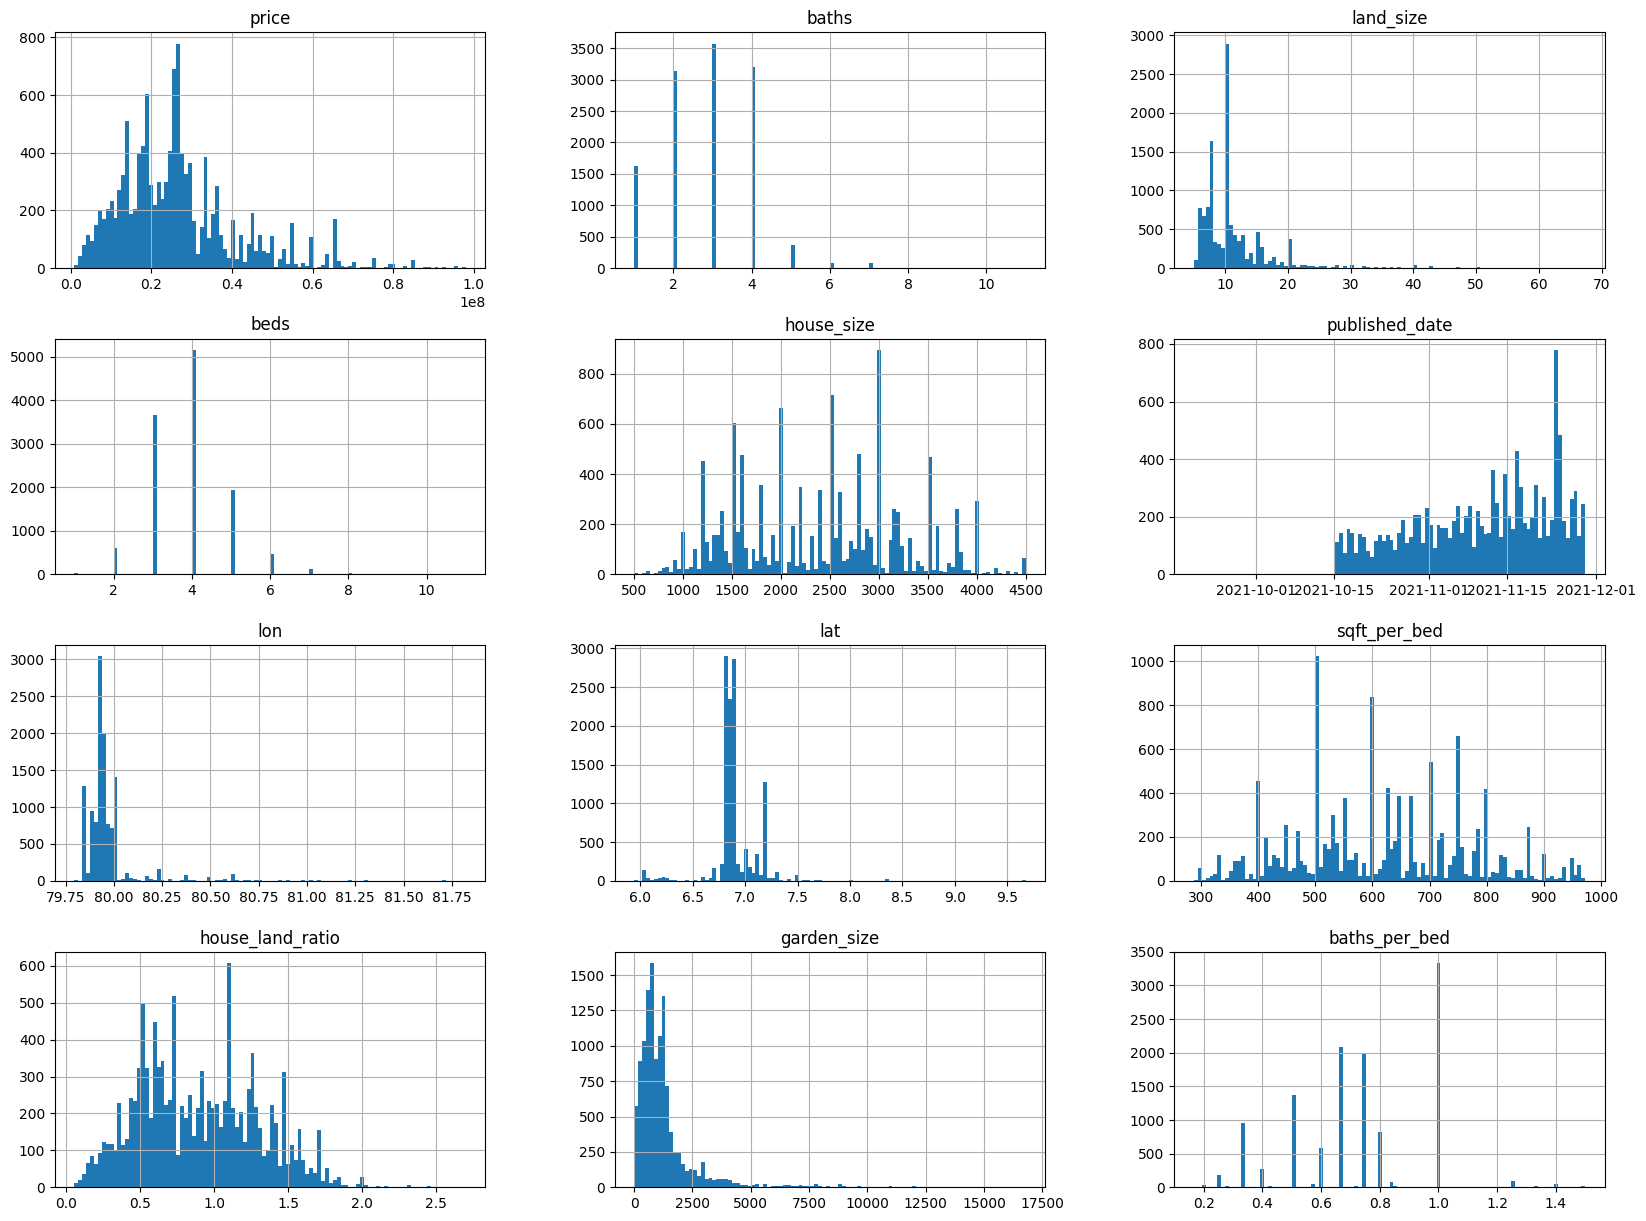

In [1055]:
df.hist(bins=100, figsize=(20,15))
plt.show()

<Axes: >

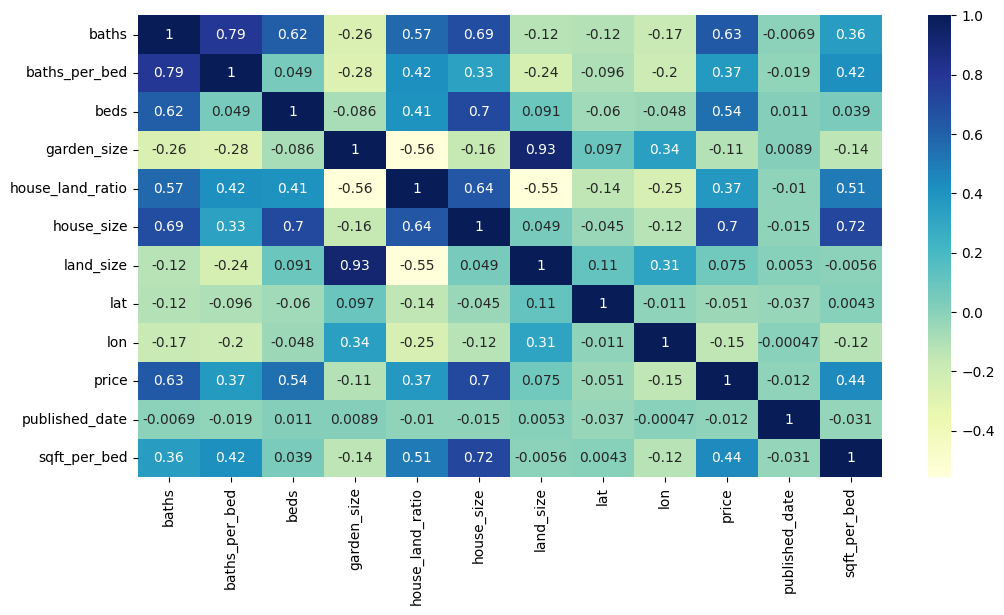

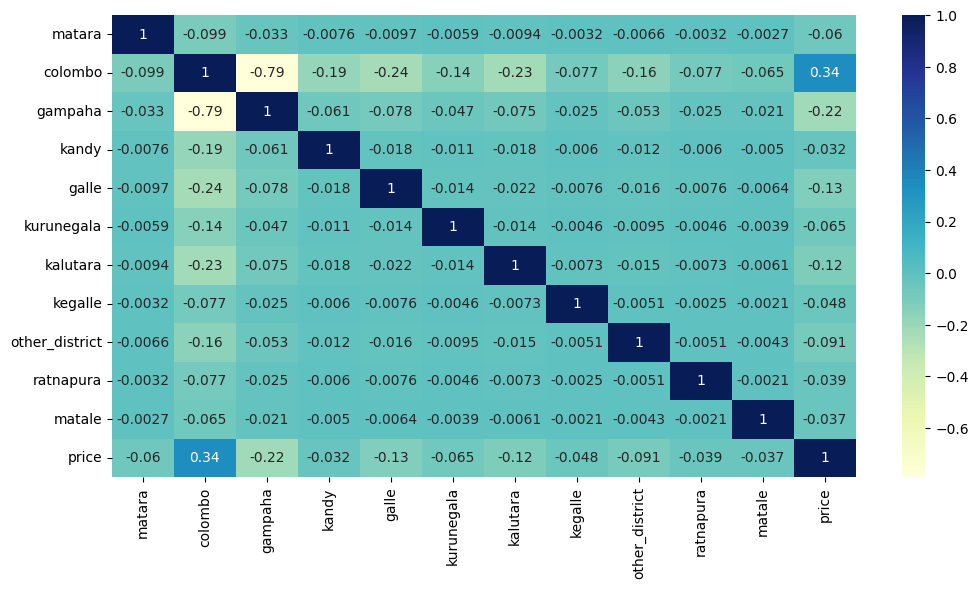

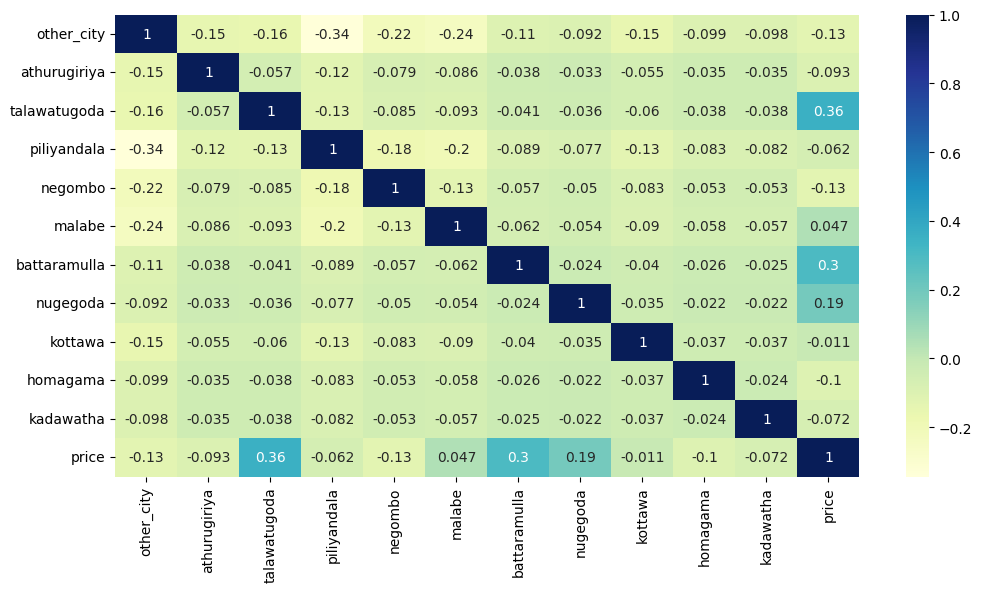

In [1056]:
import seaborn as sns
import matplotlib.pyplot as plt

others_corr = df[df.columns.difference(districts).difference(cities)].corr()
districts_corr = df[[*districts, 'price']].corr()
cities_corr = df[[*cities, 'price']].corr()

plt.figure(figsize=(12,6))
sns.heatmap(others_corr, annot=True, cmap='YlGnBu')
plt.figure(figsize=(12,6))
sns.heatmap(districts_corr, annot=True, cmap='YlGnBu')
plt.figure(figsize=(12,6))
sns.heatmap(cities_corr, annot=True, cmap='YlGnBu')



In [1057]:
# import geopandas as gpd

# # Create a GeoDataFrame from your df
# gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']))

# # Create a map
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# world = world[world['name'] == 'Sri Lanka']

# ax = world.plot(color='lightgrey', figsize=(24,12))

# cmap = plt.get_cmap('coolwarm')  # You can change 'coolwarm' to another colormap

# # Plot the scatter points on the map
# gdf.plot(ax=ax, marker='x', c=df['price'], cmap=cmap , markersize=5, label='Scatter Points')
# cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap))

# # Customize the map appearance
# plt.title('locations on map')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')

# # Show the map
# plt.legend()
# plt.show()


In [1058]:
# sri_lankan_districts = [
#     "Ampara",
#     "Anuradhapura",
#     "Badulla",
#     "Batticaloa",
#     "Colombo",
#     "Galle",
#     "Gampaha",
#     "Hambantota",
#     "Jaffna",
#     "Kalutara",
#     "Kandy",
#     "Kegalle",
#     "Kilinochchi",
#     "Kurunegala",
#     "Mannar",
#     "Matale",
#     "Matara",
#     "Monaragala",
#     "Mullaitivu",
#     "Nuwara Eliya",
#     "Polonnaruwa",
#     "Puttalam",
#     "Ratnapura",
#     "Trincomalee",
#     "Vavuniya"
# ]

# cities_df = pd.read_csv('./worldcities.csv')
# cities_df = cities_df[cities_df['country'] == 'Sri Lanka']
# cities_df = cities_df[['city', 'lat', 'lng', 'population']]
# cities_df = cities_df[cities_df['city'].isin(sri_lankan_districts)]
# cities_df.shape

# #find the nearest city for each house
# def find_nearest_city(lat, lon):
#     distances = np.sqrt((cities_df['lat'] - lat)**2 + (cities_df['lng'] - lon)**2)
#     argmin = distances.argmin()
#     return pd.Series([cities_df.iloc[argmin]['city'], distances.min(), cities_df.iloc[argmin]['population']])

# df[['nearest_main_city', 'nearest_main_city_distance', 'nearest_main_city_population']] = df.apply(lambda x: find_nearest_city(x['lat'], x['lon']), axis=1)

# df['population_distance_ratio'] = df['nearest_main_city_population'] / df['nearest_main_city_distance']

# df.head()

In [1059]:
df.describe()

,price,baths,land_size,beds,house_size,published_date,lon,lat,sqft_per_bed,house_land_ratio,garden_size,baths_per_bed
count,1.206700e+04,12067.000000,12067.000000,12067.000000,12067.000000,12067,12067.000000,12067.000000,12067.000000,12067.000000,12067.000000,12067.000000
mean,2.628401e+07,2.844203,11.435480,3.883401,2396.464508,2021-11-10 09:13:27.988729600,79.969787,6.906663,615.533313,0.896783,1324.460145,0.729402
min,9.250000e+05,1.000000,5.000000,1.000000,499.000000,2021-09-19 21:01:00,79.795675,5.941424,287.333333,0.054193,0.000000,0.166667
25%,1.650000e+07,2.000000,7.565000,3.000000,1610.000000,2021-10-31 11:32:00,79.913892,6.801844,500.000000,0.568724,578.000000,0.600000
50%,2.500000e+07,3.000000,10.000000,4.000000,2489.000000,2021-11-12 14:16:00,79.923272,6.866670,600.000000,0.864258,936.500000,0.750000
75%,3.300000e+07,4.000000,12.000000,4.000000,3000.000000,2021-11-21 10:48:30,79.989314,6.935757,733.333333,1.193756,1372.500000,1.000000
max,9.800000e+07,11.000000,67.400000,11.000000,4500.000000,2021-11-29 01:35:00,81.822554,9.673491,972.750000,2.699725,16783.750000,1.500000
std,1.459708e+07,1.157178,6.458845,1.030970,841.576473,NaN,0.159928,0.238086,150.527993,0.405297,1580.962346,0.231387


In [1060]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

if 'published_date' in df.columns:
    df = df.drop(columns=['published_date'])

# Split the dataset into features (X) and target variable (y)
X = df.drop('price', axis=1)
y = df['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate different regression models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Elastic Net': ElasticNet(alpha=1.0, l1_ratio=0.5),
    'Support Vector Regression': SVR(kernel='linear'),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1),
}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Print the statistics
    print(f"Model: {model_name}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared (R2) Score: {r2}")
    print()


Model: Linear Regression
Mean Absolute Error: 5479776.957210877
Mean Squared Error: 60303754654189.22
R-squared (R2) Score: 0.7081686681217826

Model: Ridge Regression
Mean Absolute Error: 5479354.76877032
Mean Squared Error: 60291180187232.875
R-squared (R2) Score: 0.7082295204428457



C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.438e+16, tolerance: 2.072e+14
  model = cd_fast.enet_coordinate_descent(


Model: Lasso Regression
Mean Absolute Error: 5479776.591492534
Mean Squared Error: 60303703876843.28
R-squared (R2) Score: 0.708168913851432

Model: Elastic Net
Mean Absolute Error: 6561062.073302111
Mean Squared Error: 86275550104950.98
R-squared (R2) Score: 0.5824819061427271

Model: Support Vector Regression
Mean Absolute Error: 6932912.484008204
Mean Squared Error: 109793811852114.98
R-squared (R2) Score: 0.46866866700872556

Model: Decision Tree Regressor
Mean Absolute Error: 2601635.30469122
Mean Squared Error: 39344798115807.984
R-squared (R2) Score: 0.809596518451307

Model: Random Forest Regressor
Mean Absolute Error: 2399747.5635996116
Mean Squared Error: 25636345223105.805
R-squared (R2) Score: 0.8759366010648723

Model: Gradient Boosting Regressor
Mean Absolute Error: 4272005.799746901
Mean Squared Error: 42953903727822.69
R-squared (R2) Score: 0.792130771854213

